# Automatic Modulation Classification Using Transformers
This playground demonstrates the implementation of MCformer - a Transformer based modulation classification model - as described in the following GlobeCom 2021 paper:

   [**MCformer: A Transformer Based Deep Neural Network for Automatic Modulation Classification**](https://ieeexplore.ieee.org/document/9685815)

For this experiment we use the [RadioML dataset available from DEEPSIG](https://www.deepsig.ai/datasets).

## Create a RadioML dataset
Let's first crate a RadioML dataset object and review the dataset statistics. The code in the following cell tries to download the dataset if it is not already available.

In [1]:
import numpy as np
from fireball import Model, myPrint
from fireball.datasets.radioml import RadioMlDSet

# Use the first 2 GPUs
gpus = '0,1' 

# Download the dataset if needed
RadioMlDSet.download()

# Create the training, validation, and test datasets and print the information and statistics
trainDs, testDs, validDs = RadioMlDSet.makeDatasets('train,test,valid', batchSize=128, version=2016)
RadioMlDSet.printDsInfo(trainDs, testDs, validDs)
RadioMlDSet.printStats(trainDs, testDs, validDs)

RadioMlDSet Dataset Info:
    Version ........................................ 2016
    SNR Values ..................................... All (20)
    Label Mode ..................................... MOD
    Dataset Location ............................... /home/shahab/data/RadioML/RML2016_10b/
    Number of Classes .............................. 10
    Number of Training Samples ..................... 540000
    Number of Test Samples ......................... 600000
    Number of Validation Samples ................... 60000
    Sample Shape ................................... (128, 1, 2)
    +------------+------------------+--------------------+---------------+
    | Class      | Training Samples | Validation Samples | Test Samples  |
    +------------+------------------+--------------------+---------------+
    |   0 8PSK   | 53965      9.99% | 6112        10.19% | 59923   9.99% |
    |   1 AM-DSB | 54051     10.01% | 6016        10.03% | 59933   9.99% |
    |   2 BPSK   | 54317     1

# Creating and training the MCformer Large model
Now let's create a Fireball model for MCformer Large. For more details about the network structure please refer to the paper mentioned above.

**Note**: Please note that this training could take up to 5 hours (with 2 Nvidia Titan-XP GPUs). A trained model is also available from our model zoo. To create a trained model, use the following lines to first download the model file and then instantiate a fireball model from the downloaded file.

```
Model.downloadFromZoo("MCformerLarge.fbm", "./")
model = Model.makeFromFile("MCformerLarge.fbm", 
                            trainDs=trainDs, testDs=None, validationDs=validDs,
                            gpus=gpus)
model.printLayersInfo()
model.printNetConfig()
model.initSession()
```

In [2]:
# Defining Network Layers:                                   
layersInfo=('TENSOR_S128/1/2;CONV_K1x65_O32_Ps:SeLU;'+              # Input Layer, Embedding, Normalizing
            '3*BERT_O32_I128_H4:GELU,BERT_O32_I128_H4:GELU:TP_N4;'+ # 4 BERT layers, followed by Pooling
            'FC_O128:SeLU,FC_O10,CLASS_C10')                        # 2 dense layers, classification output

model = Model(name="MCformerLarge", layersInfo = layersInfo,        # Set Name, Layers Information
              trainDs=trainDs, testDs=None, validationDs=validDs,   # Datasets used by the model
              batchSize=128, numEpochs=100,
              learningRate=(0.002,0.0002), optimizer="Adam",
              gpus=gpus)

# Print model information:
model.printLayersInfo()
model.printNetConfig()

# Start Training:
model.initSession()
model.train()

# Save the trained model:
model.save("./MCformerLarge.fbm")


Scope            InShape       Comments                 OutShape      Activ.   Post Act.        # of Params
---------------  ------------  -----------------------  ------------  -------  ---------------  -----------
IN_TENSOR        128 1 2       Tensor Shape: 128x1x2    128 1 2       None                      0          
S1_L1_CONV       128 1 2       KSP: 1x65 1 s            128 1 32      SeLU                      4,192      
S2_L1_BERT       128 1 32      32/128, 4 heads          128 32        GELU                      12,704     
S2_L2_BERT       128 32        32/128, 4 heads          128 32        GELU                      12,704     
S2_L3_BERT       128 32        32/128, 4 heads          128 32        GELU                      12,704     
S2_L4_BERT       128 32        32/128, 4 heads          128           GELU     Pooler (N=4)     12,704     
S3_L1_FC         128                                    128           SeLU                      16,512     
S3_L2_FC         128       

| 83     | 350176  | 0.0002997804  | 0.8514702 |   34.99% N/A      |
| 84     | 354395  | 0.0002997804  | 0.8512292 |   34.97% N/A      |
| 85     | 358614  | 0.00028479137 | 0.8510148 |   35.04% N/A      |
| 86     | 362833  | 0.00028479137 | 0.8505782 |   34.99% N/A      |
| 87     | 367052  | 0.0002705518  | 0.8504716 |   35.24% N/A      |
| 88     | 371271  | 0.0002705518  | 0.8499794 |   35.06% N/A      |
| 89     | 375490  | 0.0002705518  | 0.8496709 |   35.06% N/A      |
| 90     | 379709  | 0.00025702422 | 0.8496407 |   35.12% N/A      |
| 91     | 383928  | 0.00025702422 | 0.8496057 |   35.10% N/A      |
| 92     | 388147  | 0.00024417299 | 0.8490677 |   35.00% N/A      |
| 93     | 392366  | 0.00024417299 | 0.8486948 |   35.03% N/A      |
| 94     | 396585  | 0.00023196432 | 0.8485903 |   35.00% N/A      |
| 95     | 400804  | 0.00023196432 | 0.848334  |   35.15% N/A      |
| 96     | 405023  | 0.00022036611 | 0.8480029 |   35.08% N/A      |
| 97     | 409242  | 0.00022036611

# Evaluating the model at different SNRs
Now that we have a trained model, we can use the following code to evaluate the model at different SNR values using the test dataset.

Fireball's implementation of the RadioML dataset has a method called ``evaluateModel`` which allows us to pass as an argument a list of indexes of dataset samples to be considered for the evaluation. Using this capability we can evaluate the model at different SNRs. For each SNR value, we first find the indexes of the samples for that SNR, and then use them to evaluate the model.


In [3]:
# 'snrResults' will contain a list of tuples in the form of (snr, accuracy). This will be used later to draw
# a graph for accuracies at different SNRs.
snrResults = []

# Calculate accuracy for each SNR from -20 to +18
for snr in range(-20,20,2):
    # Find indexes of dataset sample for this 'snr':
    sampleIndexes = np.where(testDs.snrs==((snr/2)+10))[0]
    myPrint('\nRunning inference on %d Test Samples for SNR %d ... ' % (len(sampleIndexes), snr))
    # Evaluate the model using the specified samples from test dataset and save the resulting accuracy in the
    # list of tuples.
    snrResults += [ (snr, testDs.evaluateModel(model, sampleIndexes=sampleIndexes, expAcc=False)['accuracy']) ]

# Now calculate the overall accuracy for all samples in the test dataset.
myPrint('\nRunning inference on %d Test Samples ... ' % (testDs.numSamples))
model.evaluateDSet(testDs, expAcc=False);



Running inference on 29942 Test Samples for SNR -20 ... 
  Processed 29942 Sample. (Time: 2.74 Sec.)                              

Observed Accuracy: 0.106539

Running inference on 29932 Test Samples for SNR -18 ... 
  Processed 29932 Sample. (Time: 2.74 Sec.)                              

Observed Accuracy: 0.112421

Running inference on 30007 Test Samples for SNR -16 ... 
  Processed 30007 Sample. (Time: 3.00 Sec.)                              

Observed Accuracy: 0.125437

Running inference on 29863 Test Samples for SNR -14 ... 
  Processed 29863 Sample. (Time: 2.73 Sec.)                              

Observed Accuracy: 0.164786

Running inference on 29962 Test Samples for SNR -12 ... 
  Processed 29962 Sample. (Time: 2.75 Sec.)                              

Observed Accuracy: 0.218377

Running inference on 30019 Test Samples for SNR -10 ... 
  Processed 30019 Sample. (Time: 2.77 Sec.)                              

Observed Accuracy: 0.312236

Running inference on 30133 Test S

# Showing the results in a graph
Now we have the accuracy information for each SNR value. We can use the information in ``snrResults`` to draw this a graph.

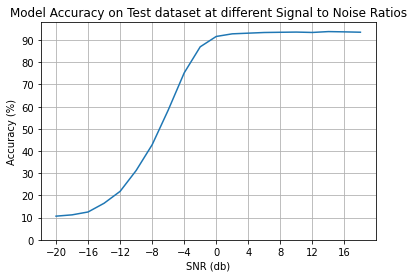

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
snrs, accuracies = zip(*snrResults)
ax.plot(snrs, np.array(accuracies)*100)
ax.set_title("Model Accuracy on Test dataset at different Signal to Noise Ratios")
plt.xlabel('SNR (db)')
plt.ylabel('Accuracy (%)')
plt.grid(axis='x')
plt.grid(axis='y')
ax.set_xticks(range(-20, 20, 4))
ax.set_yticks(range(0,100,10));


## Where do I go from here?

[Fireball Playgrounds](../Contents.ipynb)
